# "TalkingData: Predictive Model"  # Training of full data

In [1]:
# Clear workspace and memory
rm(list = ls()); gc(reset = TRUE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,496318,26.6,940480,50.3,496318,26.6
Vcells,917334,7.0,1650153,12.6,917334,7.0


In [2]:
# load libraries
if (!require("pacman")) install.packages('pacman')

Loading required package: pacman


In [3]:
pacman::p_load(knitr, tidyverse, highcharter, data.table, lubridate, janitor, 
               pROC, tictoc, DescTools, lightgbm)

In [4]:
set.seed(123)               
options(scipen = 9999, warn = -1, digits= 5)

# Data Preprocessing & Feature Engineering

In [5]:
## Pre-processing training data

# The full data set has 184 million observations. 

### Chain together and pipe training data ###

tic("Total processing time for feature engineering on training data --->")
train <- fread("train.csv", 
               col.names =c("ip", "app", "device", "os", "channel", 
                            "click_time", "attributed_time", "is_attributed"), 
               colClasses=list(numeric=1:5), 
               showProgress = FALSE) %>%
  select(-c(attributed_time)) %>%
  mutate(wday = Weekday(click_time), hour = hour(click_time)) %>% 
  select(-c(click_time)) %>%
  add_count(ip, wday, hour) %>% rename("numip_day_h" = n) %>%
  add_count(ip, hour, channel) %>% rename("numip_h_chan" = n) %>%
  add_count(ip, hour, os) %>% rename("numip_h_osr" = n) %>%
  add_count(ip, hour, app) %>% rename("numip_h_app" = n) %>%
  add_count(ip, hour, device) %>% rename("numip_h_dev" = n) %>%
  select(-c(ip))

In [6]:
dim(train)

[1] 184903890        12

In [7]:
names(train)

[1] "app"           "device"        "os"            "channel"      
 [5] "is_attributed" "wday"          "hour"          "numip_day_h"  
 [9] "numip_h_chan"  "numip_h_osr"   "numip_h_app"   "numip_h_dev"

In [8]:
head(train,2)

app,device,os,channel,is_attributed,wday,hour,numip_day_h,numip_h_chan,numip_h_osr,numip_h_app,numip_h_dev
3,1,13,379,0,1,14,1,11,168,168,892
3,1,19,379,0,1,14,1,13,143,166,842


In [9]:
toc()
invisible(gc())

Total processing time for feature engineering on training data --->: 1853.857 sec elapsed


# Let's follow the same procedure to prepare test data

In [10]:
### Chain together and pipe test data

tic("Total processing time for feature engineering on test data --->")
test  <- fread("test.csv", colClasses=list(numeric=2:6), showProgress = FALSE) 

In [11]:
# extract click_id for prediction file
sub <- data.table(click_id = test$click_id, is_attributed = NA) 
test$click_id <- NULL

In [12]:
test <- test %>% 
mutate(wday = Weekday(click_time), hour = hour(click_time)) %>%
select(-c(click_time)) %>%
add_count(ip, wday, hour) %>% rename("numip_day_h" = n) %>%
add_count(ip, hour, channel) %>% rename("numip_h_chan" = n) %>%
add_count(ip, hour, os) %>% rename("numip_h_osr" = n) %>%
add_count(ip, hour, app) %>% rename("numip_h_app" = n) %>%
add_count(ip, hour, device) %>% rename("numip_h_dev" = n) %>%
select(-c(ip))
toc()
invisible(gc())

Total processing time for feature engineering on test data --->: 214.06 sec elapsed


In [13]:
# Data analysis

# Note that I have dropped IP address, attributed time and click time columns after 
# utilizing frequency counts from IP addresses and extracting weekday and hour from click time.
# IP addresses seems to be dynamic or possibly fake so I decided to not to use for model training directly. 

### Training data

str(train)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	184903890 obs. of  12 variables:
 $ app          : num  3 3 3 14 3 3 3 3 3 64 ...
 $ device       : num  1 1 1 1 1 1 1 1 1 1 ...
 $ os           : num  13 19 13 13 13 16 23 19 13 22 ...
 $ channel      : num  379 379 379 478 379 379 379 379 379 459 ...
 $ is_attributed: int  0 0 0 0 0 0 0 0 0 0 ...
 $ wday         : num  1 1 1 1 1 1 1 1 1 1 ...
 $ hour         : int  14 14 14 14 14 14 14 14 14 14 ...
 $ numip_day_h  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ numip_h_chan : int  11 13 4 74 1 4 14 1 4 1 ...
 $ numip_h_osr  : int  168 143 172 3466 14 3 1 6 17 18 ...
 $ numip_h_app  : int  168 166 180 1038 8 27 78 4 50 1 ...
 $ numip_h_dev  : int  892 842 689 14529 37 161 351 27 161 177 ...


In [14]:
### Test data

str(test)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	18790469 obs. of  11 variables:
 $ app         : num  9 9 21 15 12 18 3 27 18 12 ...
 $ device      : num  1 1 1 1 1 1 1 1 1 1 ...
 $ os          : num  3 3 19 13 13 13 1 19 10 53 ...
 $ channel     : num  107 466 128 111 328 107 137 153 107 424 ...
 $ wday        : num  5 5 5 5 5 5 5 5 5 5 ...
 $ hour        : int  4 4 4 4 4 4 4 4 4 4 ...
 $ numip_day_h : int  34 403 229 239 60 120 90 93 106 539 ...
 $ numip_h_chan: int  2 8 10 2 2 12 2 2 5 4 ...
 $ numip_h_osr : int  3 17 69 98 27 20 6 23 1 1 ...
 $ numip_h_app : int  8 50 13 10 7 16 16 1 13 52 ...
 $ numip_h_dev : int  34 400 229 239 59 120 87 92 105 441 ...


In [15]:
## unique values by each feature in train data

kable(as.data.frame(lapply(train, function(x)length(unique(x)))))



| app| device|  os| channel| is_attributed| wday| hour| numip_day_h| numip_h_chan| numip_h_osr| numip_h_app| numip_h_dev|
|---:|------:|---:|-------:|-------------:|----:|----:|-----------:|------------:|-----------:|-----------:|-----------:|
| 706|   3475| 800|     202|             2|    4|   24|        4037|         2284|        2806|        2955|        4593|

In [16]:
## unique values by each feature in test data

kable(as.data.frame(lapply(test, function(x)length(unique(x)))))



| app| device|  os| channel| wday| hour| numip_day_h| numip_h_chan| numip_h_osr| numip_h_app| numip_h_dev|
|---:|------:|---:|-------:|----:|----:|-----------:|------------:|-----------:|-----------:|-----------:|
| 417|   1985| 395|     178|    1|    9|        1623|          795|         937|         995|        1483|

In [17]:
# Dealing with rare events data
#The complete dataset has 99.8% negative samples and 0.2% positive samples 
#which fits the definition of highly imbalanced/rare events data. 
#Let's calculate the sum of positive and negative classes in our reduced training dataset.

table(train$is_attributed)

# As we can see from the table above that, in our training the sum of positive classes is 456K 
# and sum of negative classes is 184M


        0         1 
184447044    456846 

# Modelling (LightGBM)

In [18]:
#To evaluate model performance before making prediction, let's create validation set (5% of training data) 
#on which we can measure the model performance and can make educated guess on generalizing 
#it on unseen (test) data.
#Note that this split is still by rows (time series). 
#From total observations, I'm taking first 95% rows as training and last 5% as validation data. 

## Prepare data for modeling

tr_index <- nrow(train)
dtrain <- train %>% head(0.95 * tr_index) # 95% data for training
valid <- train %>% tail(0.05 * tr_index) # 5% data for validation

In [19]:
cat("train size : ", dim(dtrain), " | valid size : ", dim(valid), " | test  size : ", dim(test))

train size :  175658695 12  | valid size :  9245195 12  | test  size :  18790469 11

In [20]:
categorical_features = c("app", "device", "os", "channel", "wday", "hour")

In [21]:
dtrain <- lgb.Dataset(data = as.matrix(dtrain[, colnames(dtrain) != "is_attributed"]), 
label = dtrain$is_attributed, categorical_feature = categorical_features)
dvalid <- lgb.Dataset(data = as.matrix(valid[, colnames(valid) != "is_attributed"]), 
label = valid$is_attributed, categorical_feature = categorical_features)

In [22]:
invisible(gc())

In [23]:
## Parameters tuning

params = list(objective = "binary", 
              metric = "auc", 
              learning_rate= 0.1, 
              num_leaves= 7,
              max_depth= 3,
              min_child_samples= 100,
              max_bin= 100, # RAM dependent as per LightGBM documentation
              subsample= 0.7,
              subsample_freq= 1,
              colsample_bytree= 0.7,
              min_child_weight= 0,
              min_split_gain= 0,
              scale_pos_weight=99) 

In [24]:
tic("Total time for model training --->")
model <- lgb.train(params, dtrain, valids = list(validation = dvalid), nthread = 4,
                   nrounds = 1000, verbose= 1, early_stopping_rounds = 30, eval_freq = 50)

[1]:	validation's auc:0.952903 
[51]:	validation's auc:0.973521 
[101]:	validation's auc:0.976899 
[151]:	validation's auc:0.978197 
[201]:	validation's auc:0.978741 
[251]:	validation's auc:0.979117 
[301]:	validation's auc:0.979328 
[351]:	validation's auc:0.979514 


In [25]:
invisible(gc())
toc()

Total time for model training --->: 1736.708 sec elapsed


In [26]:
cat("Validation AUC @ best iter: ", 
    max(unlist(model$record_evals[["validation"]][["auc"]][["eval"]])))

Validation AUC @ best iter:  0.97951

# Model evaluation

In [28]:
## Understanding importance of each measure

### Gain
#The **Gain** measure implies the relative contribution of the corresponding feature 
#to the model calculated by taking each feature's contribution for each tree in the model. 
#A higher value of this metric when compared to another feature implies it is more 
#important for generating a prediction.
#This is also the most relevant attribute to interpret the relative importance of each feature. 
#Based on feature importance matrix, 
#we can choose to eliminate feature with lowest (near zero) gain 
#and try and test new features in order to improve model performance. 

## Feature importance

# get feature importance
fi <- lgb.importance(model, percentage = TRUE)

fi %>% select(Feature, Gain) %>% mutate(Gain = sprintf("%0.4f", Gain)) %>% kable()



|Feature      |Gain   |
|:------------|:------|
|app          |0.6341 |
|numip_h_dev  |0.1362 |
|channel      |0.1159 |
|numip_h_app  |0.0443 |
|numip_day_h  |0.0215 |
|os           |0.0204 |
|numip_h_osr  |0.0109 |
|device       |0.0096 |
|hour         |0.0037 |
|numip_h_chan |0.0032 |
|wday         |0.0002 |

In [29]:
### Cover
#The **Cover** metric measures the relative quantity of observations concerned by a feature.


fi %>% select(Feature, Cover) %>% mutate(Cover = sprintf("%0.3f", Cover)) %>% arrange(desc(Cover)) %>% kable()



|Feature      |Cover |
|:------------|:-----|
|app          |0.246 |
|channel      |0.200 |
|os           |0.139 |
|numip_h_dev  |0.103 |
|numip_day_h  |0.068 |
|numip_h_app  |0.066 |
|hour         |0.062 |
|numip_h_osr  |0.046 |
|device       |0.043 |
|numip_h_chan |0.025 |
|wday         |0.003 |

In [30]:
### Frequency
#The **Frequency** measure is the percentage representing the relative number of times 
#a particular feature occurs in the trees of the model. 
#In simple words, it tells us how often the feature is used in the model.


fi %>% select(Feature, Frequency) %>% 
mutate(Frequency = sprintf("%0.3f", Frequency)) %>% 
arrange(desc(Frequency)) %>% 
kable()



|Feature      |Frequency |
|:------------|:---------|
|app          |0.256     |
|channel      |0.226     |
|os           |0.141     |
|numip_h_dev  |0.077     |
|numip_day_h  |0.066     |
|hour         |0.065     |
|numip_h_app  |0.056     |
|numip_h_osr  |0.051     |
|device       |0.030     |
|numip_h_chan |0.025     |
|wday         |0.007     |


Call:
roc.default(response = valid$is_attributed, predictor = val_preds,     levels = base::levels(as.factor(valid$is_attributed)), plot = TRUE,     grid = TRUE, col = "steelblue", lwd = 3)

Data: val_preds in 9958 controls (valid$is_attributed 0) < 42 cases (valid$is_attributed 1).
Area under the curve: 0.979

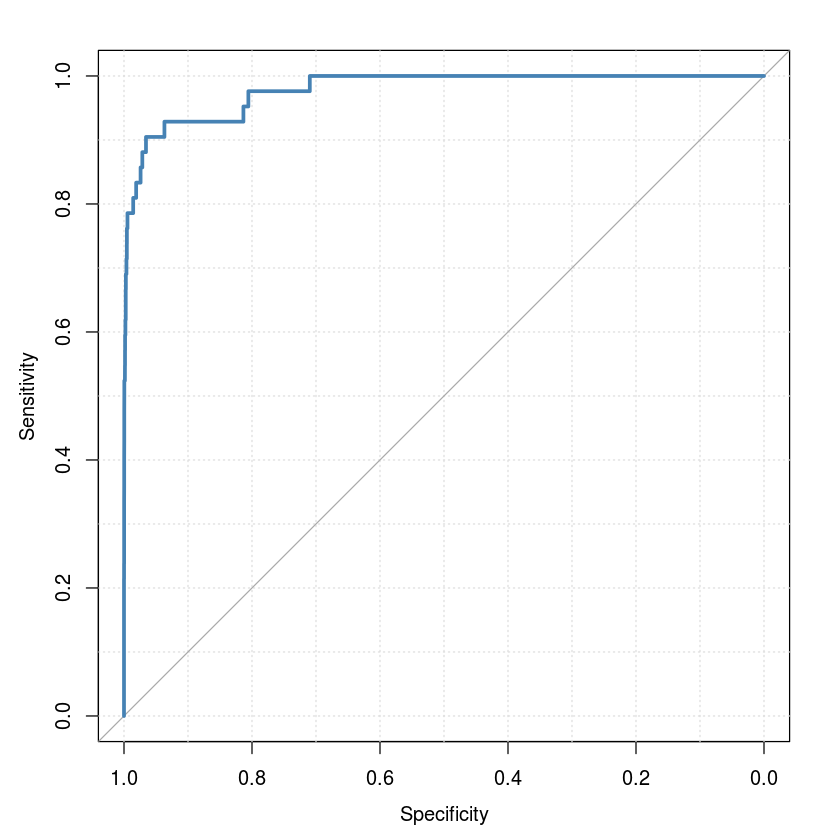

In [31]:
## ROC on validation set

# An ROC curve demonstrates several things for 2-class classification algorithms:
# 
# - It shows the tradeoff between sensitivity and specificity 
# (any increase in sensitivity will be accompanied by a decrease in specificity).
# - The closer the curve follows the left-hand border and then the top border of the ROC space, 
# the more accurate the test.
# - The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

#To reduce the computation time for this example, 
#I'm reducing original validation data set to first 10,000 observations.


valid <- head(valid, 10000)

# get predictions on reduced validation set
val_preds = predict(model, data = as.matrix(valid[, colnames(valid) != "is_attributed"]), 
                    n = model$best_iter)

#plot ROC
auc.lgb = roc(valid$is_attributed, val_preds, 
              levels=base::levels(as.factor(valid$is_attributed)), grid=TRUE,
              plot = TRUE, col = "steelblue", lwd = 3)
auc.lgb
invisible(gc())

In [32]:
## Understanding individual prediction based on importance values

# Let's take the first observation in validation dataset 
# and compare it with actual and predicted values based on feature importance 
# to find out the reason behind having that specific predicted value. 

## Select random Observation in validation set

kable(valid[57, ]) #let's choose the 57th observation



| app| device| os| channel| is_attributed| wday| hour| numip_day_h| numip_h_chan| numip_h_osr| numip_h_app| numip_h_dev|
|---:|------:|--:|-------:|-------------:|----:|----:|-----------:|------------:|-----------:|-----------:|-----------:|
|   3|      1| 19|     115|             0|    4|   13|         225|            9|         142|         151|         614|

In [33]:
## Compare with predicted value

cat(paste("predicted value from model: ", val_preds[[57]]))

predicted value from model:  0.00767759950058344

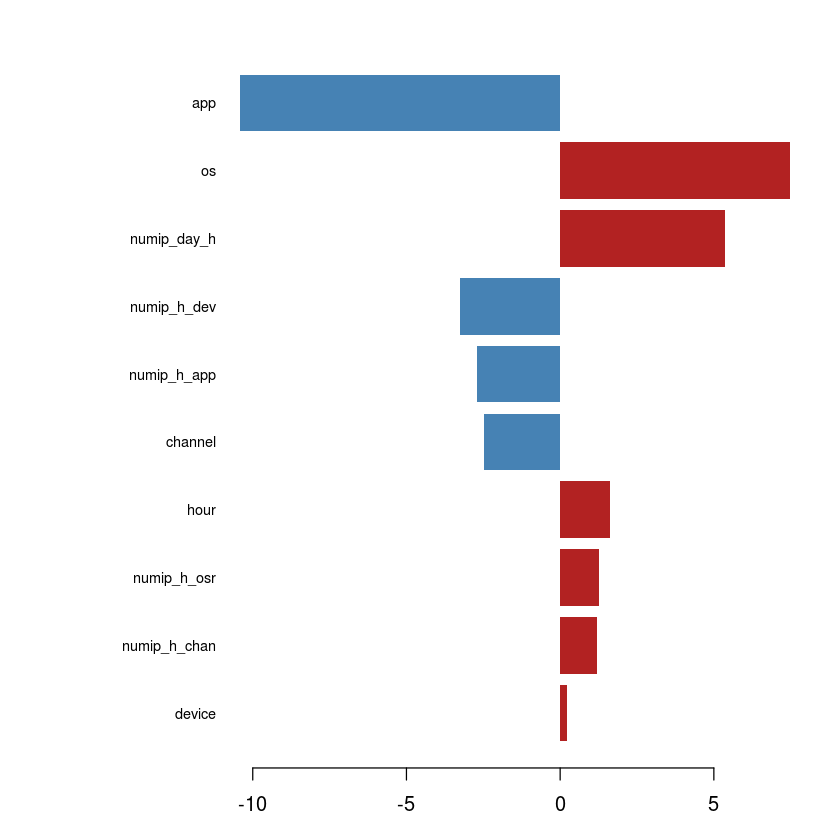

In [34]:
## Reasoning
#lgb.interprete function computes feature contribution components of rawscore prediction. 
#We will use it with plot.interpretation argument for visual representation.


#extract interpretation for 1st observation in validation data
tree_interpretation <- lgb.interprete(model, data = as.matrix(valid[, colnames(valid)]), 1)
lgb.plot.interpretation(tree_interpretation[[1]])

# In the chart above, X axis refers to contribution value (positive/ negative) 
# and Y axis refers to name of the feature. 
# We can see the features with their contribution (positive/ negative) from the plot 
# and the table below to get an idea behind why our model predicted that 
# specific value for chosen observation in validation data set.

In [35]:
# In the table below, features and their contribution for prediction is arranged in descending order.
as.data.frame(tree_interpretation) %>% arrange(desc(Contribution)) %>% kable()
rm(valid, valid_preds)
invisible(gc())



|Feature      | Contribution|
|:------------|------------:|
|os           |      7.46423|
|numip_day_h  |      5.34886|
|hour         |      1.60540|
|numip_h_osr  |      1.25425|
|numip_h_chan |      1.19718|
|device       |      0.23229|
|wday         |     -0.09519|
|channel      |     -2.47497|
|numip_h_app  |     -2.71065|
|numip_h_dev  |     -3.25661|
|app          |    -10.41482|

In [36]:
# Lets do Predictions on test records -ncol(test)
preds <- predict(model, data = as.matrix(test[1:18790469, colnames(test)], n = model$best_iter),reshape = TRUE)

In [37]:
#predicting on test set
head(preds,5)  # showing first 5 predictions

[1] 0.042033 0.042531 0.005618 0.024947 0.013247

In [38]:
preds <- as.data.frame(preds)

In [39]:
head(sub,5)

click_id,is_attributed
0,NA
1,NA
2,NA
3,NA
4,NA


In [40]:
sub$is_attributed <- preds

In [41]:
head(sub,5)

click_id,is_attributed
0,0.042033
1,0.042531
2,0.005618
3,0.024947
4,0.013247


In [42]:
#converting probabilities into 0 or 1
prob2class = function(is_attributed){
    if(is_attributed>=.5){
      return(1)
    } else {
      return(0)
    }
}

In [43]:
# apply prob2class function on each row of dataframe
sub$is_attributed_target <- sapply(sub$is_attributed,prob2class)

In [44]:
head(sub,5)

click_id,is_attributed,is_attributed_target
0,0.042033,0
1,0.042531,0
2,0.005618,0
3,0.024947,0
4,0.013247,0


In [45]:
table(sub$is_attributed_target)


       0        1 
18341733   448736 

In [46]:
sub$is_attributed <- NULL

In [47]:
names(sub)

[1] "click_id"             "is_attributed_target"

In [48]:
head(sub,5)

click_id,is_attributed_target
0,0
1,0
2,0
3,0
4,0


In [49]:
dim(sub)

[1] 18790469        2

In [50]:
colnames(sub)[2] <- "is_attributed"

In [51]:
colnames(sub)

[1] "click_id"      "is_attributed"

In [52]:
head(sub,5)

click_id,is_attributed
0,0
1,0
2,0
3,0
4,0


In [54]:
table(sub$is_attributed)


       0        1 
18341733   448736 

In [55]:
fwrite(sub, "sample_submission.csv")